# Introduction to Climate Networks for global 2m air temperature anomalies

## Data loading

In [34]:
# imports needed
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import plot_utils as put
import scipy.stats as st
from importlib import reload

In [7]:
ds = xr.open_dataset('./data/era5_t2m_2.5_monmean_ds.nc')
ds

<xarray.Dataset>
Dimensions:  (time: 492, lat: 73, lon: 144)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2019-12-01
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 174.7 177.2 179.8
Data variables:
    t2m      (time, lat, lon) float32 ...

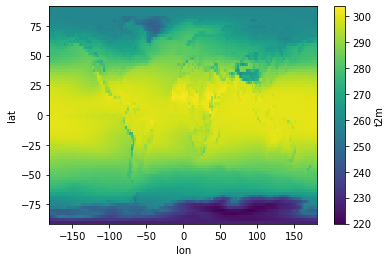

In [8]:
var_name = 't2m'
ds[var_name].mean(dim='time').plot()

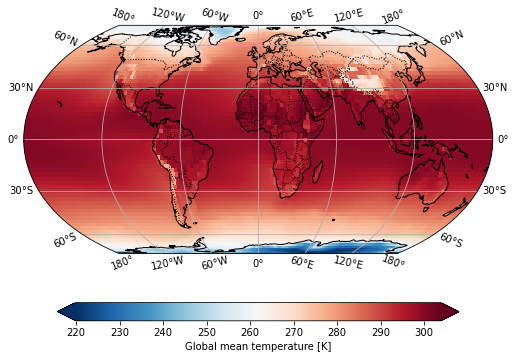

In [35]:
reload(put)
mean_t2m = ds[var_name].mean(dim='time')
im = put.plot_map(mean_t2m, label='Global mean temperature [K]', projection='EqualEarth')

## Preprocess Data

### Detrend data and create anomaly time series
Plot the average global mean temperature: Why do we see an increase?

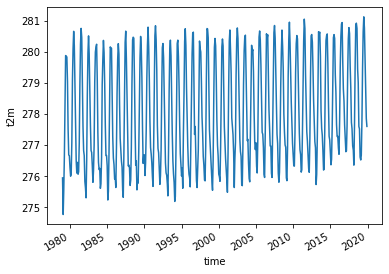

In [20]:
# Plot the average yearly temperature
ds[var_name].mean(dim='lon').mean('lat').plot()

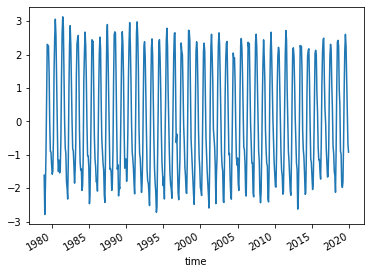

In [28]:
# Compute the fit coefficients
p = ds[var_name].polyfit(dim='time', deg=1)
# Apply the fit
fit = xr.polyval(ds['time'], p.polyfit_coefficients)
da_detrend = ds[var_name] - fit
da_detrend.mean(dim='lon').mean('lat').plot()


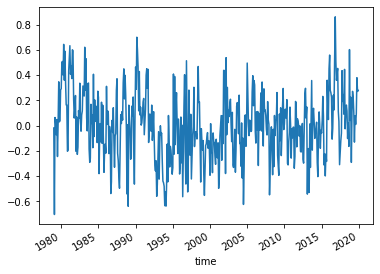

In [33]:
# Now compute anomaly time series 
group = 'dayofyear'
climatology = (
            da_detrend.groupby(f"time.{group}").mean(dim="time")
        )
anomalies = da_detrend.groupby(f"time.{group}") - climatology
anomalies.mean(dim='lon').mean('lat').plot()
ds['anomalies'] = anomalies


In [62]:
ds['anomalies'].shape


(492, 73, 144)

## Now compute all pair-wise correlations

In [47]:
da = ds['anomalies']  # Use the anomaly data to compute the pairwise correlations
print('Dataset shape: ', da.shape)
dim_time, dim_lat, dim_lon = da.shape
# Bring all into a form of an array of time series
data = []
data = []
for idx, t in enumerate(da.time):
        buff = da.sel(time=t.data).data.flatten()  # flatten each time step
        buff[np.isnan(buff)] = 0.0  # set missing data to climatology
        data.append(buff)
data = np.array(data)
print('Flattend Dataset shape: ', data.shape)


Dataset shape:  (492, 73, 144)
Flattend Dataset shape:  (492, 10512)


In [54]:
corr, pvalue =  st.spearmanr(
        data, axis=0, nan_policy='propagate')
print('Shape of correlation Matrix: ', corr.shape)

Shape of correlation Matrix:  (10512, 10512)


Not all correlations are statistically significant.
Let's first exclude non-significant correlations

In [55]:
confidence = 0.999
mask_confidence = np.where(pvalue <= (1 - confidence), 1, 0)  # p-value test
corr = np.where(mask_confidence==1, corr, 0)

In [59]:
# get minimum value that is still accounted as a correlation
np.nanmin(np.where(np.abs(corr) != 0, np.abs(corr), np.nan))

0.14790797759462537

Now finally compute the adjacency matrix of the network

In [60]:
threshold = 0.4  # absolute threshold for correlations
mask_correlation = np.where(np.abs(corr) >= threshold, 1, 0)

# A link in the adjacency is placed for all significant values above the threshold
adjacency = mask_confidence * mask_correlation

# Obtain sparsity of adjacency matrix.
sparsity = (
    np.count_nonzero(adjacency.flatten()) / adjacency.shape[0]**2
)
print("Sparsity of adjacency: ", sparsity)

Sparsity of adjacency:  0.022751341367638983
